## Parse PDF
Tools for parsing PDFs have come a long way in the past couple years, and new tools are emerging almost daily. This notebook explores a handfull of libraries for suitability for our task. We are seeking a library that can return a high fidelity representation of a variety of PDF formats, including PDFs with complex layouts, tables and images. A more verbose review of available libraries is available on my [knowledge base](https://io.eriktuck.com/base/parse+pdf).

In [ ]:
from io import BytesIO
import os

import requests

/home/erikt/_dev/world-bank-kg/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def download_pdf(url):
    """Download PDF from a URL and return it as bytes."""
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download {url}")
    return BytesIO(response.content)

def group_into_windows(chunks, window_size=3, overlap=1):
    """Group chunks into sliding windows with optional overlap."""
    grouped = []
    i = 0
    while i < len(chunks):
        group = chunks[i:i + window_size]
        grouped.append("\n\n".join(group))
        i += window_size - overlap
    return grouped

def save_to_markdown(grouped_chunks, output_path):
    """Save grouped chunks to a markdown file."""
    with open(output_path, "w", encoding="utf-8") as f:
        for i, group in enumerate(grouped_chunks, 1):
            f.write(f"## Chunk {i}\n\n{group}\n\n---\n\n")


Partition and Chunk from url

In [77]:
from unstructured.partition.auto import partition
from unstructured.staging.base import elements_to_json
from unstructured.chunking.title import chunk_by_title

pdf_url = "https://documents1.worldbank.org/curated/en/995361468056343658/pdf/529200PAD0P0801for0disclosure0final.pdf"
base_output_name = "unstructured_output"

# pdf_bytes = download_pdf(pdf_url)
# elements = partition_pdf(url=pdf_url, infer_table_structure=True, strategy="hi_res", languages=["eng"])
elements = partition(url=pdf_url, infer_table_structure=True, strategy="hi_res", languages=["eng"])

elements_to_json(elements=elements, filename=f"{base_output_name}.json")

chunks = chunk_by_title(elements)

with open(f'{base_output_name}.md', "w", encoding="utf-8") as f:
    for i, chunk in enumerate(chunks, 1):
        f.write(f"## Chunk {i}\n\n{chunk}\n\n---\n\n")

INFO: Reading PDF for file: /tmp/tmpnqwkkw1g/document.pdf ...
INFO: Loading the Table agent ...
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
INFO: Loading the table structure model ...
INFO: Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO: [timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO: Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Patition and Chunk locally (to test for differences in approaches, if any)

In [6]:
from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import elements_to_json
from unstructured.chunking.title import chunk_by_title

pdf_fname = "../test.pdf"
base_output_name = "unstructured_output_local"

elements = partition_pdf(filename=pdf_fname, strategy="hi_res")

elements_to_json(elements=elements, filename=f"{base_output_name}.json")

chunks = chunk_by_title(elements)

with open(f'{base_output_name}.md', "w", encoding="utf-8") as f:
    for i, chunk in enumerate(chunks, 1):
        f.write(f"## Chunk {i}\n\n{chunk}\n\n---\n\n")

## Mistral OCR

In [12]:
import os
from mistralai import Mistral
from dotenv import load_dotenv
load_dotenv(dotenv_path="../secrets/.env")

pdf_url = "https://documents1.worldbank.org/curated/en/995361468056343658/pdf/529200PAD0P0801for0disclosure0final.pdf"

api_key = os.environ["MISTRAL_API_KEY"]
client = Mistral(api_key=api_key)

ocr_response = client.ocr.process(
    model="mistral-ocr-latest",
    document={
        "type": "document_url",
        "document_url": pdf_url
    },
    include_image_base64=True
)

In [22]:
from pathlib import Path

def save_ocr_markdown_from_pages(ocr_response, output_path: str):
    """Save combined markdown from Mistral OCR response to a .md file."""
    all_markdown = []

    for page in ocr_response.pages:
        md = getattr(page, "markdown", "").strip()
        if md:
            all_markdown.append(md)

    full_markdown = "\n\n---\n\n".join(all_markdown)
    Path(output_path).write_text(full_markdown, encoding="utf-8")
    print(f"✅ Markdown saved to {output_path}")


In [23]:
save_ocr_markdown_from_pages(ocr_response, "output_mistral.md")

✅ Markdown saved to output_mistral.md


In [32]:
import re
from pathlib import Path

def save_markdown_with_inline_images(ocr_response, output_path: str):
    """Embed base64 images inline in markdown from Mistral OCR output."""
    all_markdown = []

    for page in ocr_response.pages:
        markdown = getattr(page, "markdown", "")

        # Build a map from image reference ID to base64-encoded string
        image_map = {
            img.id: img.image_base64 for img in getattr(page, "images", [])
        }

        # Replace all image references with inline base64
        def replace_img(match):
            alt_text = match.group(1)
            img_id = match.group(2)
            base64_data = image_map.get(img_id)
            if base64_data:
                return f"![{alt_text}]({base64_data})"
            else:
                return match.group(0)  # Leave unchanged if image not found

        # Find markdown image syntax like ![...](img-2.jpeg)
        markdown = re.sub(r'!\[([^\]]*)\]\((img-[\w\d\-\.]+\.jpeg)\)', replace_img, markdown)
        all_markdown.append(markdown.strip())

    # Combine all pages with horizontal breaks
    full_markdown = "\n\n---\n\n".join(all_markdown)
    Path(output_path).write_text(full_markdown, encoding="utf-8")
    print(f"✅ Markdown with inline images saved to {output_path}")


In [33]:
save_markdown_with_inline_images(ocr_response, "output_mistral_inline.md")

✅ Markdown with inline images saved to output_mistral_inline.md


## MinerU

In [39]:
from pathlib import Path
import re
from typing import List

def chunk_markdown_text(path: str, max_words: int = 150, overlap: int = 30) -> List[str]:
    """Chunk a markdown document into overlapping windows of approximately `max_words`."""
    text = Path(path).read_text(encoding="utf-8")

    # Remove image tags and metadata (optional cleanup)
    text = re.sub(r'!\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'---+', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()
    chunks = []
    start = 0

    while start < len(words):
        end = start + max_words
        chunk = " ".join(words[start:end])
        chunks.append(chunk)
        start += max_words - overlap  # shift window with overlap

    return chunks

In [40]:
chunks = chunk_markdown_text("output_mistral_inline.md", max_words=150, overlap=30)
print(f"🔹 {len(chunks)} chunks created")
print(chunks[0])

🔹 183 chunks created
Document of The World Bank # FOR OFFICIAL USE ONLY Report No: 52920-MX PROJECT APPRAISAL DOCUMENT<br>ON A<br>PROPOSED PURCHASE OF EMISSIONS REDUCTIONS<br>BY THE SPANISH CARBON FUND AND THE BIO CARBON FUND<br>IN THE AMOUNT OF<br>US\$ 17,473,211<br>FROM THE<br>COMISION FEDERAL DE ELECTRICIDAD (MEXICO)<br>FOR THE<br>WIND UMBRELLA (LA VENTA II) PROJECT April 24, 2006 This document has a restricted distribution and may be used by recipients only in the performance of their official duties. Its contents may not otherwise be disclosed without World Bank authorization. # CURRENCY EQUIVALENTS (Exchange Rate Effective \{January 2006\}) Currency Unit $=$ Mexican Peso 1 Mexican Peso $=$ US $\$ 0.095$ $$ 1 \mathrm{US} \$=0.7916 € $$ FISCAL YEAR January 1 - December 31 ## ABBREVIATIONS AND ACRONYMS BLT Build-Lease-Transfer BM Build Margin emission factor BOT Build-Operate-Transfer CAS Country Assistance Strategy CDM Clean Development Mechanism CENACE National Center of Energy Co

In [41]:
from keybert import KeyBERT
from typing import List

def extract_keywords_from_chunks(chunks: List[str], top_n: int = 5, diversity: float = 0.5):
    model = KeyBERT(model="all-MiniLM-L6-v2")

    all_keywords = []
    for i, chunk in enumerate(chunks):
        keywords = model.extract_keywords(
            chunk,
            keyphrase_ngram_range=(1, 3),
            stop_words="english",
            use_mmr=True,
            diversity=diversity,
            top_n=top_n
        )
        all_keywords.append({
            "chunk_index": i,
            "text": chunk[:200] + "...",
            "keywords": [kw[0] for kw in keywords]
        })
    
    return all_keywords

In [42]:
import pandas as pd
results = extract_keywords_from_chunks(chunks, top_n=5, diversity=0.7)
df_keywords = pd.DataFrame(results)
df_keywords

,chunk_index,text,keywords
0,0,Document of The World Bank # FOR OFFICIAL USE ...,"[currency unit mexican, fund bio carbon, recip..."
1,1,Margin emission factor BOT Build-Operate-Trans...,"[mexican national grid, operating margin emiss..."
2,2,Value OM Operating Margin emission factor O\&M...,"[mexican petroleum petróleos, impact budgetary..."
3,3,President: | Pamela Cox | | :--: | :--: | | Co...,"[bank spanish carbon, health project financing..."
4,4,Loan [ ] Credit [ ] Grant [ ] Guarantee [X] Ot...,"[spanish carbon fund, loans credits, cfe estim..."
...,...,...,...
178,178,| | Current budget balance | -1.2 | 3.3 | 2.2 ...,"[export price index, imports cif 15, fuel ener..."
179,179,"| Capital goods | 2,573 | 12,322 | 20,208 | 22...","[2004 exports goods, balance payments millions..."
180,180,"| -10,076 | -12,012 | -12,082 | -10,938 | | Ne...","[reserves including gold, net current transfer..."
181,181,"| | Total debt outstanding and disbursed | 94,...","[total debt service, foreign direct investment..."


## Unstructured with LangChain

In [45]:
from langchain_unstructured import UnstructuredLoader

pdf_fname = "../test.pdf"

loader_local = UnstructuredLoader(
    web_url=pdf_url,
    strategy="hi_res",
)
pages = []
for doc in loader_local.lazy_load():
    pages.append(doc)

INFO: Reading PDF for file: /tmp/tmpxniqezi4/document.pdf ...


In [63]:
from langchain_unstructured import UnstructuredLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

load_dotenv(dotenv_path="../secrets/.env")

loader = UnstructuredLoader(
    web_url=pdf_url,
    strategy="hi_res",
)
docs = loader.load()


INFO: Reading PDF for file: /tmp/tmpf2xxso5x/document.pdf ...


/tmp/ipykernel_52766/2580436936.py:19: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  summary_chain = LLMChain(llm=llm, prompt=summary_prompt)
/tmp/ipykernel_52766/2580436936.py:21: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  summary = summary_chain.run({"content": docs[0].page_content})
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [68]:
docs[0]

Document(metadata={'coordinates': {'points': ((np.float64(22.416666666666668), np.float64(63.16666666666669)), (np.float64(22.416666666666668), np.float64(78.61111111111099)), (np.float64(50.19444444444444), np.float64(78.61111111111099)), (np.float64(50.19444444444444), np.float64(63.16666666666669))), 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}, 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 1, 'url': 'https://documents1.worldbank.org/curated/en/995361468056343658/pdf/529200PAD0P0801for0disclosure0final.pdf', 'category': 'UncategorizedText', 'element_id': 'cc2e446cc861bbd1ef64169433b56250'}, page_content='d')

In [ ]:

# Step 2: Summarize
llm = ChatOpenAI(model_name="gpt-4o")
summary_prompt = PromptTemplate.from_template("Summarize the document:\n\n{content}")
summary_chain = LLMChain(llm=llm, prompt=summary_prompt)

summary = summary_chain.run({"content": docs[0].page_content})

# Step 3: Extract keywords
keyword_prompt = PromptTemplate.from_template("Extract keywords:\n\n{content}")
keywords = LLMChain(llm=llm, prompt=keyword_prompt).run({"content": docs[0].page_content})

# Step 4: Chunking
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = splitter.split_documents(docs)

In [70]:
from langchain.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader(pdf_fname)
docs = loader.load()
text = "\n\n".join([doc.page_content for doc in docs])
text

"Document of \nThe World Bank \n \nFOR OFFICIAL USE ONLY \n \nReport No: 52920-MX  \n \n \n \n \nPROJECT APPRAISAL DOCUMENT \n \nON A \n \nPROPOSED PURCHASE OF EMISSIONS REDUCTIONS \n \nBY THE SPANISH CARBON FUND AND THE BIO CARBON FUND \n \nIN THE AMOUNT OF  \nUS$ 17,473,211 \n \nFROM THE \n \nCOMISION FEDERAL DE ELECTRICIDAD \n(MEXICO) \n \nFOR THE \n \nWIND UMBRELLA (LA VENTA II) PROJECT \n \n \nApril 24, 2006 \n \n \nThis document has a restricted distribution and may be used by recipients only in the \nperformance of their official duties.  Its contents may not otherwise be disclosed without World \nBank authorization. \n \nPublic Disclosure Authorized\nPublic Disclosure Authorized\nPublic Disclosure Authorized\nPublic Disclosure Authorized\nPublic Disclosure Authorized\nPublic Disclosure Authorized\nPublic Disclosure Authorized\nPublic Disclosure Authorized\n\nCURRENCY EQUIVALENTS \n \n(Exchange Rate Effective {January 2006}) \nCurrency Unit = Mexican Peso \n1 Mexican Peso  = US$

In [76]:
from openai import OpenAI
from IPython.display import Markdown, display

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def stream_markdown_response():
    md_output = ""
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that extracts keywords, acronyms, and summaries from technical PDFs."},
            {"role": "user", "content": text[:100_000]}
        ],
        stream=True,
        temperature=0.2
    )

    for chunk in response:
        if hasattr(chunk.choices[0].delta, "content"):
            token = chunk.choices[0].delta.content
            md_output += token
            print(token, end="")
    
    display(Markdown(md_output))
    return md_output

stream_markdown_response()

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


future costs of these fuels, the economic benefits of the La Venta II project could be higher than estimated if fossil fuel prices increase. The analysis assumes a conservative estimate of US$0.04/kWh for the opportunity cost of electricity generation, which is used to calculate the economic benefits of the project.

Greenhouse Gas Emissions Reductions (benefits). The project will reduce approximately 190,000 tons of CO2 equivalent annually by displacing electricity generated from fossil fuels with wind energy. The economic value of these emissions reductions is based on the market price for carbon credits, which was estimated at US$10 per ton of CO2e at the time of analysis. This provides an additional revenue stream that enhances the project's economic viability.

The main economic costs of the wind energy project are: (i) the investment necessary for the construction of the project; and (ii) the costs of operation and maintenance.

The cost-benefit analysis for the La Venta II proje

TypeError: can only concatenate str (not "NoneType") to str

In [74]:
len(text)*.8

103239.20000000001

In [81]:
import requests
from pathlib import Path
from tempfile import NamedTemporaryFile
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.schema import Document

def download_pdf_to_file(url: str) -> Path:
    """Download a PDF and write it to a temp file. Return the file path."""
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download {url}")

    temp_file = NamedTemporaryFile(delete=False, suffix=".pdf")
    temp_file.write(response.content)
    temp_file.flush()
    return Path(temp_file.name)

def parse_pdf_with_llamaindex(file_path: Path, metadata: dict = None) -> list[Document]:
    """Use PyMuPDFReader to parse a PDF from file path."""
    reader = PyMuPDFReader()
    documents = reader.load_data(file_path)

    if metadata:
        for doc in documents:
            doc.metadata.update(metadata)

    return documents

# --- Usage Example ---
url = "https://documents1.worldbank.org/curated/en/995361468056343658/pdf/529200PAD0P0801for0disclosure0final.pdf"
file_path = download_pdf_to_file(url)
documents = parse_pdf_with_llamaindex(file_path, metadata={"source": url})

print(documents[0].text[:1000])


 
 
  Document of 
The World Bank 
 
FOR OFFICIAL USE ONLY 
 
Report No: 52920-MX  
 
 
 
 
PROJECT APPRAISAL DOCUMENT 
 
ON A 
 
PROPOSED PURCHASE OF EMISSIONS REDUCTIONS 
 
BY THE SPANISH CARBON FUND AND THE BIO CARBON FUND 
 
IN THE AMOUNT OF  
US$ 17,473,211 
 
FROM THE 
 
COMISION FEDERAL DE ELECTRICIDAD 
(MEXICO) 
 
FOR THE 
 
WIND UMBRELLA (LA VENTA II) PROJECT 
 
 
April 24, 2006 
 
 
This document has a restricted distribution and may be used by recipients only in the 
performance of their official duties.  Its contents may not otherwise be disclosed without World 
Bank authorization. 
 
Public Disclosure Authorized
Public Disclosure Authorized
Public Disclosure Authorized
Public Disclosure Authorized
Public Disclosure Authorized
Public Disclosure Authorized
Public Disclosure Authorized
Public Disclosure Authorized



In [83]:
def save_documents_to_markdown(documents: list[Document], output_md_path: str):
    """Concatenate parsed Document text and save it to a Markdown file."""
    full_text = "\n\n".join(doc.text for doc in documents)
    Path(output_md_path).write_text(full_text, encoding="utf-8")
    print(f"✅ Markdown saved to {output_md_path}")

save_documents_to_markdown(documents, "output_pymupdf.md")

✅ Markdown saved to output_pymupdf.md


In [84]:
import requests
from pathlib import Path
from tempfile import NamedTemporaryFile
from llama_index.readers.file import UnstructuredReader
from llama_index.core.schema import Document

def download_pdf_to_file(url: str) -> Path:
    """Download a PDF from a URL and save it to a temporary file."""
    response = requests.get(url)
    response.raise_for_status()
    temp_file = NamedTemporaryFile(delete=False, suffix=".pdf")
    temp_file.write(response.content)
    temp_file.flush()
    return Path(temp_file.name)

def parse_pdf_exclude_tables(file_path: Path, metadata: dict = None) -> list[Document]:
    """Parse the PDF using UnstructuredReader and exclude tables."""
    reader = UnstructuredReader()
    documents = reader.load_data(file_path)

    # Filter out table elements (Unstructured tags them with metadata)
    filtered_docs = [doc for doc in documents if doc.metadata.get("category") != "Table"]

    if metadata:
        for doc in filtered_docs:
            doc.metadata.update(metadata)

    return filtered_docs

def save_documents_to_markdown(documents: list[Document], output_md_path: str):
    """Save parsed document text (excluding tables) to markdown file."""
    full_text = "\n\n".join(doc.text for doc in documents)
    Path(output_md_path).write_text(full_text, encoding="utf-8")
    print(f"✅ Markdown saved to {output_md_path}")

# --- Usage Example ---
url = "https://documents1.worldbank.org/curated/en/995361468056343658/pdf/529200PAD0P0801for0disclosure0final.pdf"
pdf_file = download_pdf_to_file(url)
docs = parse_pdf_exclude_tables(pdf_file, metadata={"source": url})
save_documents_to_markdown(docs, "output_unstructured_li.md")


✅ Markdown saved to output_unstructured_li.md


## PDFplumber

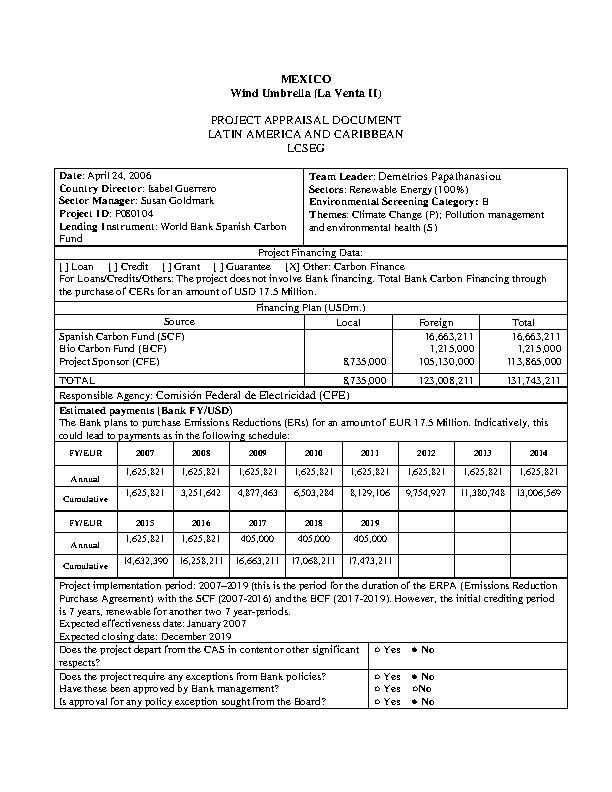

In [ ]:
import pdfplumber

pdf = pdfplumber.open(pdf_fname)

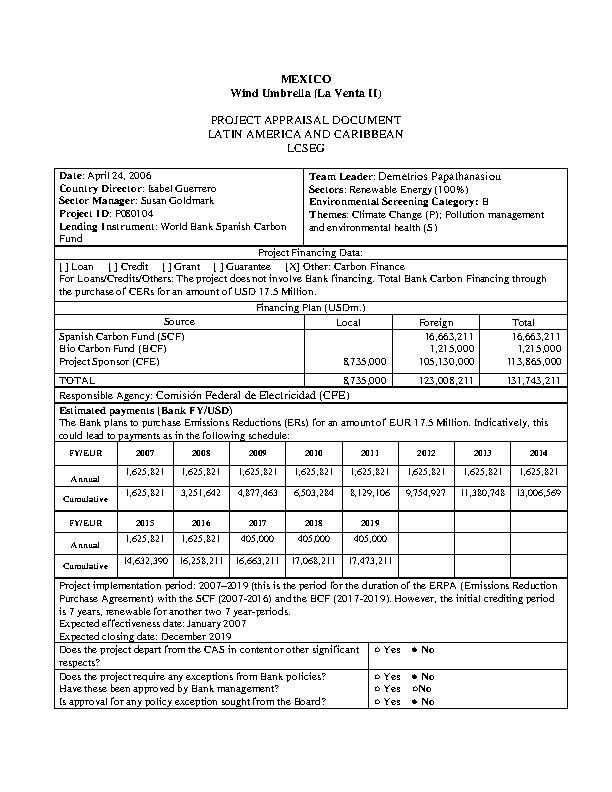

In [109]:
p3 = pdf.pages[3]
im = p3.to_image()
im

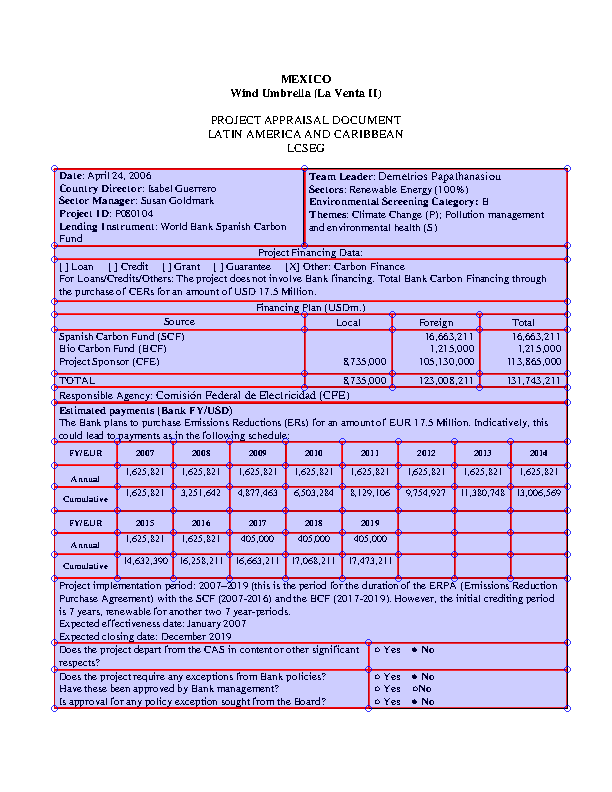

In [110]:
im.reset().debug_tablefinder()

In [107]:
table_settings = {
    "vertical_strategy": "lines",
    "horizontal_strategy": "text",
    "snap_y_tolerance": 6,
    "intersection_x_tolerance": 15
}

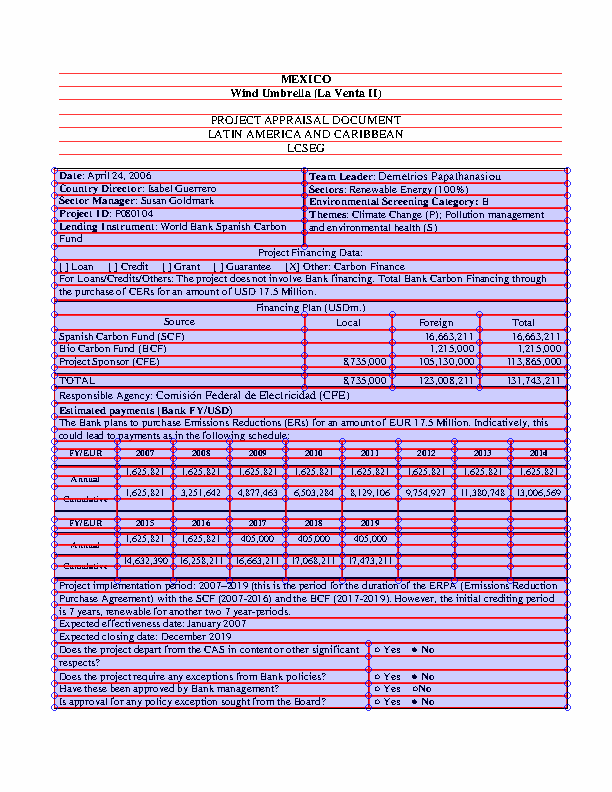

In [108]:
im.reset().debug_tablefinder(table_settings)

In [113]:
pd.DataFrame(table)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,"Date: April 24, 2006\nCountry Director: Isabel...",None,None,None,None,Team Leader: Demetrios Papathanasiou\nSectors:...,None,None,None,None,None,None,None
1,Project Financing Data:,None,None,None,None,None,None,None,None,None,None,None,None
2,[ ] Loan [ ] Credit [ ] Grant [ ] Guarantee [X...,None,None,None,None,None,None,None,None,None,None,None,None
3,Financing Plan (USDm.),None,None,None,None,None,None,None,None,None,None,None,None
4,Source,None,None,None,None,Local,None,None,Foreign,None,None,Total,None
5,Spanish Carbon Fund (SCF)\nBio Carbon Fund (BC...,None,None,None,None,"8,735,000",None,None,"16,663,211\n1,215,000\n105,130,000",None,None,"16,663,211\n1,215,000\n113,865,000",None
6,TOTAL,None,None,None,None,"8,735,000",None,None,"123,008,211",None,None,"131,743,211",None
7,Responsible Agency: Comisión Federal de Electr...,None,None,None,None,None,None,None,None,None,None,None,None
8,Estimated payments (Bank FY/USD)\nThe Bank pla...,None,None,None,None,None,None,None,None,None,None,None,None
9,FY/EUR,2007,2008,2009,2010,None,2011,None,None,2012,2013,None,2014


In [115]:
from langchain_community.document_loaders import PyPDFLoader


pdf_loader = PyPDFLoader(pdf_fname)
documents = pdf_loader.load()

In [116]:
documents[3]

Document(metadata={'producer': 'Microsoft® Office Word 2007 / PDF PT 3.40p (pdf-tools.com) / PDF PT 3.40p (pdf-tools.com)', 'creator': 'Microsoft® Office Word 2007', 'creationdate': '2010-02-18T23:06:09+00:00', 'author': 'World Bank Group', 'moddate': 'D:20160713154630', 'title': 'World Bank Document', 'source': '../test.pdf', 'total_pages': 60, 'page': 3, 'page_label': '4'}, page_content='MEXICO \nWind Umbrella (La Venta II) \n \nPROJECT APPRAISAL DOCUMENT \nLATIN AMERICA AND CARIBBEAN \nLCSEG \n \nDate: April 24, 2006     \nCountry Director: Isabel Guerrero \nSector Manager: Susan Goldmark \nProject ID: P080104 \nLending Instrument: World Bank Spanish Carbon \nFund \nTeam Leader: Demetrios Papathanasiou        \nSectors: Renewable Energy (100%) \nEnvironmental Screening Category: B \nThemes: Climate Change (P); Pollution management \nand environmental health (S) \nProject Financing Data: \n[ ] Loan     [ ] Credit     [ ] Grant     [ ] Guarantee     [X] Other: Carbon Finance \nFor Loa